In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os
import glob
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from PIL import Image
import hashlib
import seaborn as sns
import tensorflow as tf

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### **Data Cleaning**

In [4]:
# Generating a list of paths for every file in the 'Testing' and 'Training' folders (the original folders from the Kaggle dataset)

main_directories = ['/content/drive/MyDrive/Data 255 Project Data/Testing', '/content/drive/MyDrive/Data 255 Project Data/Training']

image_paths = []

for directory in main_directories:
    for subdir, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')):
                full_path = os.path.join(subdir, file)
                image_paths.append(full_path)

In [11]:
# Checking if any of the image files are corrupt

def verify_images(image_paths):
    bad_image_counter = 0
    for image_path in image_paths:
        try:
            img = Image.open(image_path)
            img.verify()
        except:
            print('Bad file located at:', image_path)
            bad_image_counter += 1
    if bad_image_counter == 0:
        print("No bad files found.")

verify_images(image_paths)

No bad files found.


In [14]:
# Checking if any of the image files are corrupt, using OpenCV

def verify_images_opencv(image_paths):
    corrupt_images = []
    for image_path in image_paths:
        img = cv2.imread(image_path)
        if img is None:
            corrupt_images.append(image_path)
    return corrupt_images

corrupt_images = verify_images_opencv(image_paths)

if len(corrupt_images)==0:
    print("No bad files found.")
else:
    for img in corrupt_images:
        print('Corrupt image detected at path:', img)

No bad files found.


In [12]:
# Removing images that are too small or too large

def remove_images_by_size(image_paths, min_size=(32, 32), max_size=(2048, 2048)):
    for image_path in image_paths:
        img = Image.open(image_path)
        if img.size < min_size or img.size > max_size:
            print(f'Removing image at path {image_path} due to size {img.size}')
            os.remove(image_path)

remove_images_by_size(image_paths = image_paths)

In [17]:
# Removing non-image files

def remove_non_image_files(image_paths):
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff')
    for image_path in image_paths:
        if not image_path.endswith(valid_extensions):
            print(f'Removing non-image file: {image_path}')
            os.remove(image_path)

remove_non_image_files(image_paths)

### **Initial Data Preparation**

In [ ]:
# Renaming the files in each subfolder of the Testing folder so they do not overlap when creating a dataframe later

root_directory = '/content/drive/MyDrive/Data 255 Project Data/Testing'

for subdir, dirs, files in os.walk(root_directory):
    for file in files:
        first_letter = os.path.basename(subdir)[0]
        file_name, file_extension = os.path.splitext(file)
        new_file_name = f"{file_name}_{first_letter}{file_extension}"
        old_file_path = os.path.join(subdir, file)
        new_file_path = os.path.join(subdir, new_file_name)
        os.rename(old_file_path, new_file_path)

print("Files have been renamed.")

Files have been renamed.


In [ ]:
# Creating a dataframe with columns Id and Class, with all of the original testing images

root_dir = '/content/drive/MyDrive/Data 255 Project Data/Testing'
folders = os.listdir(root_dir)

data = []

for folder in folders:
    folder_path = os.path.join(root_dir, folder)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                data.append({'Id': file, 'Class': folder})

test_df = pd.DataFrame(data)
test_df.head()

,Id,Class
0,image(6)_p.jpg,pituitary_tumor
1,image(7)_p.jpg,pituitary_tumor
2,image(22)_p.jpg,pituitary_tumor
3,image(37)_p.jpg,pituitary_tumor
4,image(47)_p.jpg,pituitary_tumor


In [ ]:
test_df.to_csv("/content/drive/MyDrive/Data 255 Project Data/test_df.csv", index=False)

In [ ]:
# Copying the images from the 4 classes in the Testing Set into 1 folder

root_dir = '/content/drive/MyDrive/Data 255 Project Data/Testing'
destination_dir = '/content/drive/MyDrive/Data 255 Project Data/All Testing Images'

if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

for folder in os.listdir(root_dir):
    folder_path = os.path.join(root_dir, folder)
    if folder_path == destination_dir:
        continue
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                file_path = os.path.join(folder_path, file)
                dest_path = os.path.join(destination_dir, file)
                shutil.copy(file_path, dest_path)

print("Files have been copied.")

Files have been copied.


In [ ]:
# Creating a dataframe with columns Id and Class, with all of the original training images

root_dir = '/content/drive/MyDrive/Data 255 Project Data/Training'
folders = os.listdir(root_dir)

data = []

for folder in folders:
    folder_path = os.path.join(root_dir, folder)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                data.append({'Id': file, 'Class': folder})

full_train_and_val_df = pd.DataFrame(data)
full_train_and_val_df.head()

,Id,Class
0,gg (232).jpg,glioma_tumor
1,gg (329).jpg,glioma_tumor
2,gg (159).jpg,glioma_tumor
3,gg (423).jpg,glioma_tumor
4,gg (462).jpg,glioma_tumor


In [ ]:
full_train_and_val_df.to_csv("/content/drive/MyDrive/Data 255 Project Data/full_train_and_val_df.csv", index=False)

In [ ]:
# Copying the images from the 4 classes in the Training Set into 1 folder

root_dir = '/content/drive/MyDrive/Data 255 Project Data/Training'
destination_dir = '/content/drive/MyDrive/Data 255 Project Data/All Training and Validation Images'

if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

for folder in os.listdir(root_dir):
    folder_path = os.path.join(root_dir, folder)
    if folder_path == destination_dir:
        continue
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                file_path = os.path.join(folder_path, file)
                dest_path = os.path.join(destination_dir, file)
                shutil.copy(file_path, dest_path)

print("Files have been copied.")

Files have been copied.


In [ ]:
# Splitting the full training and validation set into 90% for training and 10% for validation

train_df, val_df = train_test_split(full_train_and_val_df, test_size=0.1, stratify=full_train_and_val_df['Class'])

In [ ]:
train_df.to_csv("/content/drive/MyDrive/Data 255 Project Data/train_df.csv", index=False)
val_df.to_csv("/content/drive/MyDrive/Data 255 Project Data/val_df.csv", index=False)

In [ ]:
os.makedirs('/content/drive/MyDrive/Data 255 Project Data/All Training Images', exist_ok=True)
os.makedirs('/content/drive/MyDrive/Data 255 Project Data/All Validation Images', exist_ok=True)

In [ ]:
# Copying the images from the full training and validation images folder to separate training and validation folders

source_directory = '/content/drive/MyDrive/Data 255 Project Data/All Training and Validation Images'
train_directory = '/content/drive/MyDrive/Data 255 Project Data/All Training Images'
validation_directory = '/content/drive/MyDrive/Data 255 Project Data/All Validation Images'

def copy_images(df, source_dir, destination_dir):
    for image_id in df['Id']:
      file_path = os.path.join(source_dir, image_id)
      if os.path.isfile(file_path):
        shutil.copy(file_path, destination_dir)
    print("Files copied successfully.")

copy_images(train_df, source_directory, train_directory)
copy_images(val_df, source_directory, validation_directory)

Files copied successfully.
Files copied successfully.


### **Data Exploration**

In [ ]:
# Defining the base directory
base_dir = "/content/drive/MyDrive/Data 255 Project Data"

# Loading the training, validation, and test dataframes
train_df = pd.read_csv(f"{base_dir}/train_df.csv")
val_df = pd.read_csv(f"{base_dir}/val_df.csv")
test_df = pd.read_csv(f"{base_dir}/test_df.csv")

train_image_dir = f'{base_dir}/All Training Images'

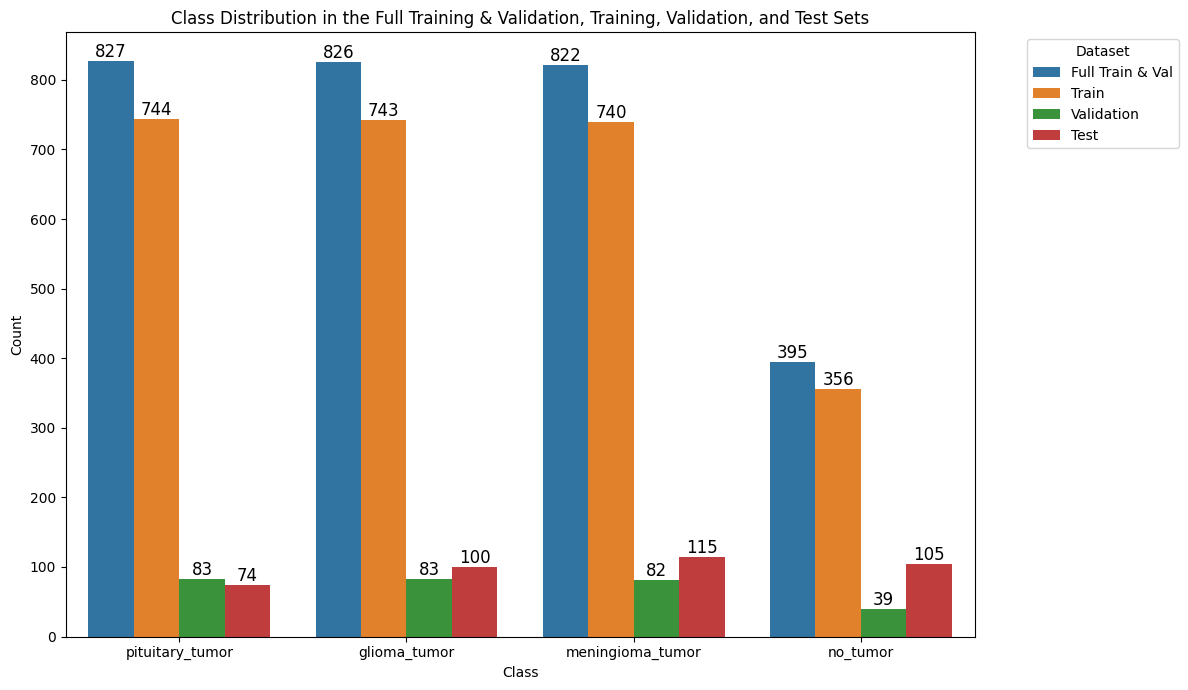

In [ ]:
# Showing the class distributions of all of the datasets in the same graph

full_train_and_val_df = pd.read_csv(f"{base_dir}/full_train_and_val_df.csv")

# Grouping by the 'Class' column and counting the occurrences in each dataframe
full_train_val_class_counts = full_train_and_val_df['Class'].value_counts().reset_index()
full_train_val_class_counts.columns = ['Class', 'Full Train & Val']

train_class_counts = train_df['Class'].value_counts().reset_index()
train_class_counts.columns = ['Class', 'Train']

val_class_counts = val_df['Class'].value_counts().reset_index()
val_class_counts.columns = ['Class', 'Validation']

test_class_counts = test_df['Class'].value_counts().reset_index()
test_class_counts.columns = ['Class', 'Test']

merged_df = pd.merge(full_train_val_class_counts, train_class_counts, on='Class', how='outer')
merged_df = pd.merge(merged_df, val_class_counts, on='Class', how='outer')
merged_df = pd.merge(merged_df, test_class_counts, on='Class', how='outer')
merged_df = merged_df.fillna(0)

melted_df = pd.melt(merged_df, id_vars=['Class'], value_vars=['Full Train & Val', 'Train', 'Validation', 'Test'])

plt.figure(figsize=(12, 7))
sns.barplot(data=melted_df, x='Class', y='value', hue='variable', hue_order=['Full Train & Val', 'Train', 'Validation', 'Test'])

# Adding counts above the bars
for p in plt.gca().patches:
    plt.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()),
             fontsize=12, ha='center', va='bottom')

plt.title('Class Distribution in the Full Training & Validation, Training, Validation, and Test Sets')
plt.xlabel('Class')
plt.ylabel('Count')
plt.legend(title='Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

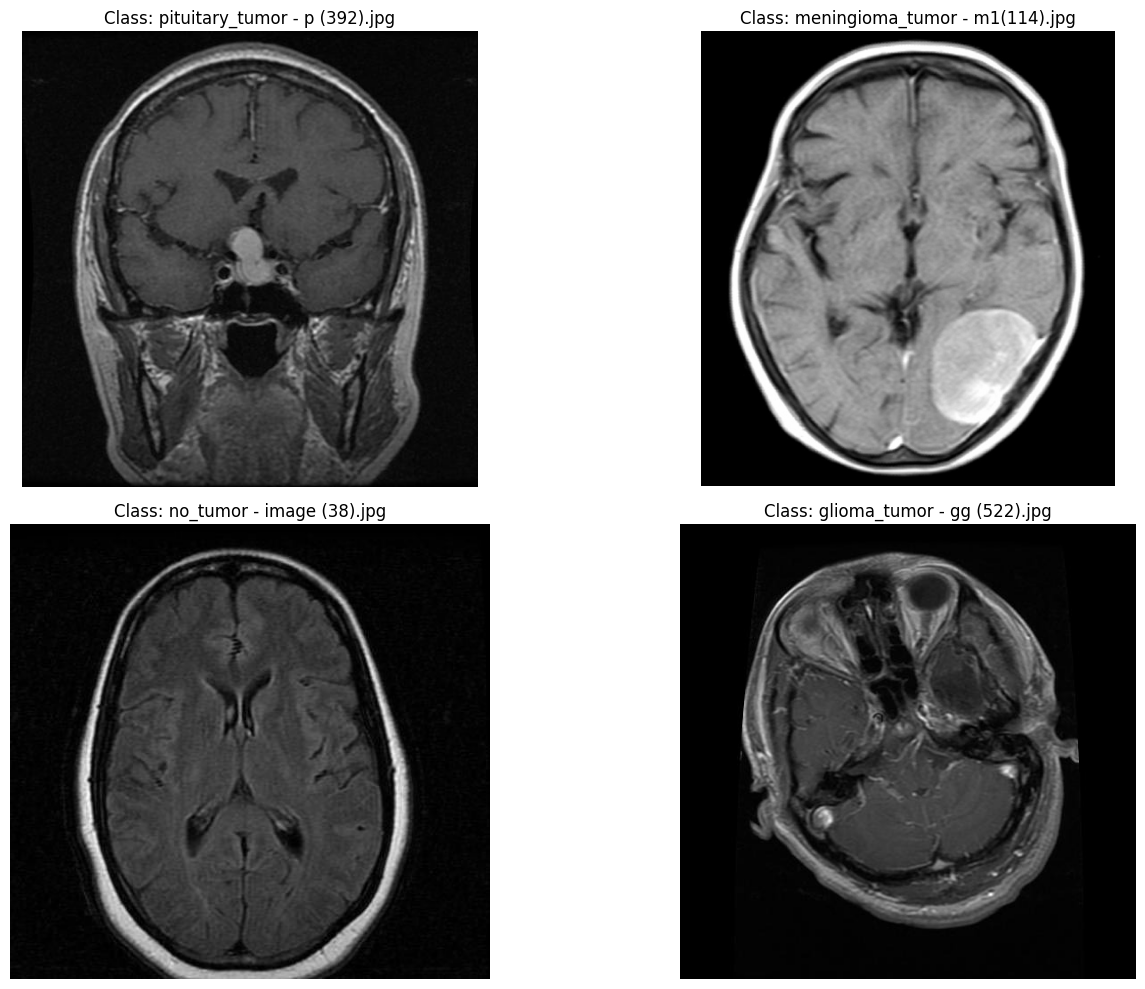

In [ ]:
# Displaying raw images - 1 for each class

# Function to display a grid of images
def display_images(image_paths, titles, cols=2):
    rows = (len(image_paths) + cols - 1) // cols
    plt.figure(figsize=(15, rows * 5))
    for i, (image_path, title) in enumerate(zip(image_paths, titles)):
        plt.subplot(rows, cols, i + 1)
        img = mpimg.imread(image_path)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Function to get a sample image from a class with a set random seed
def get_sample_image(df, image_dir, class_label, n=1, seed=45):
    np.random.seed(seed)
    sample_df = df[df['Class'] == class_label].sample(n, random_state=seed)
    image_path = os.path.join(image_dir, sample_df.iloc[0]['Id'])
    title = f"Class: {class_label} - {os.path.basename(image_path)}"
    return image_path, title

unique_classes = train_df['Class'].unique()

# Displaying one image for each class in a grid with 2 columns
image_paths = []
titles = []
for class_label in unique_classes:
    image_path, title = get_sample_image(train_df, train_image_dir, class_label)
    image_paths.append(image_path)
    titles.append(title)

display_images(image_paths, titles, cols=2)

In [ ]:
# Creating augmented images for the train set (to generate more examples and have balanced classes during the training process)

# Directory where the augmented images will be saved
augmented_images_dir = f'{base_dir}/augmented_only_train'
os.makedirs(augmented_images_dir, exist_ok=True)

# Initializing the dataframe to hold information for the augmented images
augmented_only_train_df = pd.DataFrame(columns=['Id', 'Class'])

# Defining the augmentation function
def augment_image(image, image_id, class_label, augmentation_counter):
    augmented_images = []
    # Removing the file extension from the original image_id
    base_image_id = os.path.splitext(image_id)[0]
    # Applying each augmentation function
    for i in range(augmentation_counter):
        augmented = image
        augmented = tf.image.rot90(augmented, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)) # rotates image by 0, 90, 180, or 270 degrees
        augmented = tf.image.random_contrast(augmented, lower=0.8, upper=1.2)
        augmented = tf.image.random_brightness(augmented, max_delta=0.1)
        augmented = tf.clip_by_value(augmented, 0, 255)

        # Saving the augmented image
        new_image_id = f"{base_image_id}_{i}.jpg"
        new_image_path = os.path.join(augmented_images_dir, new_image_id)
        tf.io.write_file(new_image_path, tf.io.encode_jpeg(augmented))

        # Adding the information to the list (to be added to a dataframe later)
        augmented_images.append({'Id': new_image_id, 'Class': class_label})

    return augmented_images


# Augmenting the images per class in the train set to reach 1200 images each
for class_label, group in train_df.groupby('Class'):
    num_images_to_augment = 1200 - len(group)
    if num_images_to_augment > 0:
        images_to_augment = group.sample(n=num_images_to_augment, replace=True)
        for idx, row in images_to_augment.iterrows():
            image_path = os.path.join(train_image_dir, row['Id'])
            image = tf.io.read_file(image_path)
            image = tf.io.decode_image(image, channels=3)
            # Performing the actual augmentation
            augmented_images_info = augment_image(image, row['Id'], row['Class'], 1)
            # Appending the augmented images info to the specified dataframe
            augmented_only_train_df = augmented_only_train_df.append(augmented_images_info, ignore_index=True)


# Saving the dataframe of augmented images
augmented_only_train_df.to_csv('/content/drive/MyDrive/Data 255 Project Data/augmented_only_train_df.csv', index=False)

<ipython-input-29-0e8f932351cf>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_only_train_df = augmented_only_train_df.append(augmented_images_info, ignore_index=True)
<ipython-input-29-0e8f932351cf>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_only_train_df = augmented_only_train_df.append(augmented_images_info, ignore_index=True)
<ipython-input-29-0e8f932351cf>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_only_train_df = augmented_only_train_df.append(augmented_images_info, ignore_index=True)
<ipython-input-29-0e8f932351cf>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_only_trai

In [ ]:
train_df_with_augmentation = pd.concat([train_df, augmented_only_train_df], ignore_index=True)

In [ ]:
train_df_with_augmentation.to_csv('/content/drive/MyDrive/Data 255 Project Data/train_df_with_augmentation.csv', index=False)

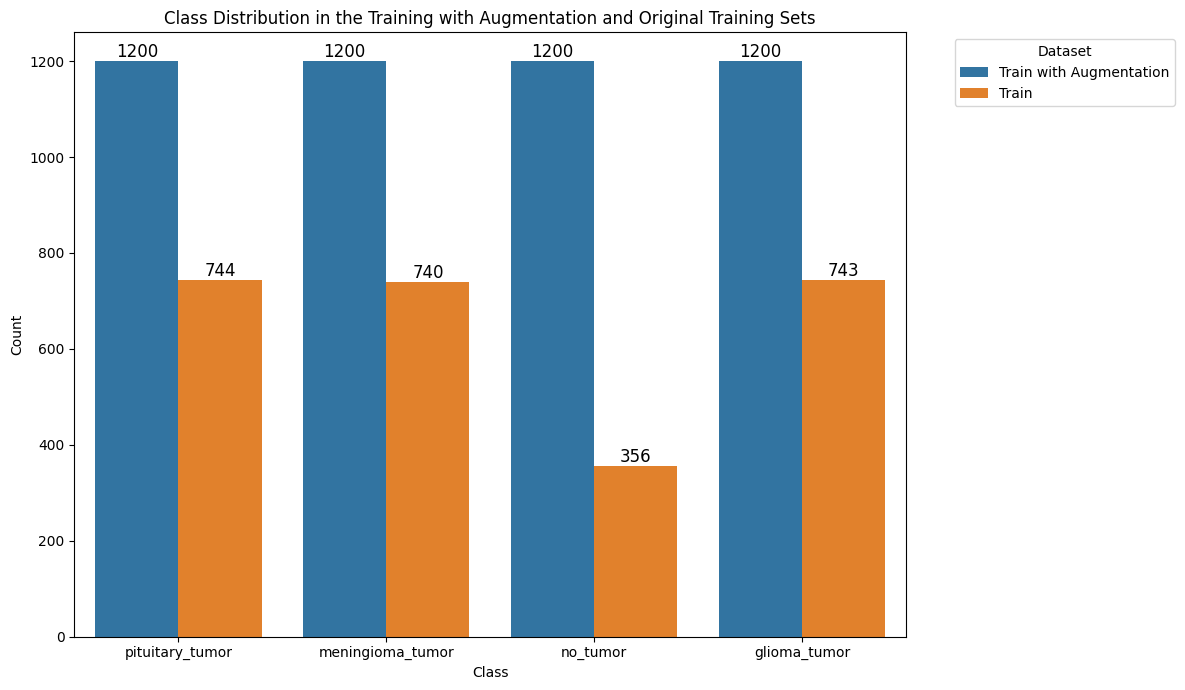

In [ ]:
# Showing the class distributions of the train dataset with augmentation, and the original train dataset in the same graph

# Grouping by the 'Class' column and counting the occurrences in each dataframe
full_train_augmentation_class_counts = train_df_with_augmentation['Class'].value_counts().reset_index()
full_train_augmentation_class_counts.columns = ['Class', 'Train with Augmentation']

train_class_counts = train_df['Class'].value_counts().reset_index()
train_class_counts.columns = ['Class', 'Train']

merged_df = pd.merge(full_train_augmentation_class_counts, train_class_counts, on='Class', how='outer')
merged_df = merged_df.fillna(0)

melted_df = pd.melt(merged_df, id_vars=['Class'], value_vars=['Train with Augmentation', 'Train'])

plt.figure(figsize=(12, 7))
sns.barplot(data=melted_df, x='Class', y='value', hue='variable', hue_order=['Train with Augmentation', 'Train'])

# Adding counts above the bars
for p in plt.gca().patches:
    plt.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()),
             fontsize=12, ha='center', va='bottom')

plt.title('Class Distribution in the Training with Augmentation and Original Training Sets')
plt.xlabel('Class')
plt.ylabel('Count')
plt.legend(title='Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Creating a folder with the combined Train Images and Augmented Images

folder_A = '/content/drive/MyDrive/Data 255 Project Data/All Training Images'
folder_B = '/content/drive/MyDrive/Data 255 Project Data/augmented_only_train'
folder_C = '/content/drive/MyDrive/Data 255 Project Data/All Training Images with Augmentation'

os.makedirs(folder_C, exist_ok=True)

# Copying images from folder A to folder C
for image_path in glob.glob(os.path.join(folder_A, '*')):
    shutil.copy(image_path, folder_C)

# Copying images from folder B to folder C
for image_path in glob.glob(os.path.join(folder_B, '*')):
    shutil.copy(image_path, folder_C)

print("Files copied successfully.")

Files copied successfully.


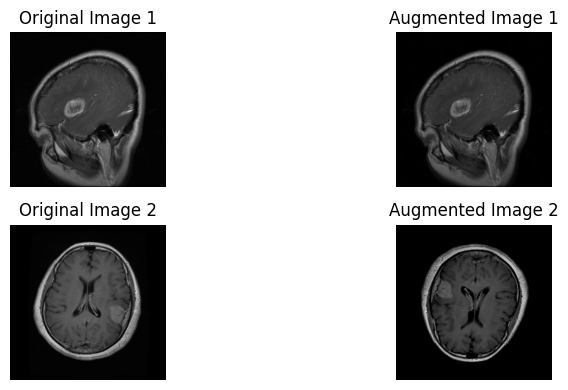

In [ ]:
# Displaying a couple augmented images and the original image side-by-side

# Paths to the original and augmented images
original_image_paths = ['/content/drive/MyDrive/Data 255 Project Data/All Training Images/gg (103).jpg', '/content/drive/MyDrive/Data 255 Project Data/All Training Images/m (129).jpg']
augmented_image_paths = ['/content/drive/MyDrive/Data 255 Project Data/augmented_only_train/gg (103)_0.jpg', '/content/drive/MyDrive/Data 255 Project Data/augmented_only_train/m (129)_0.jpg']

# Function to load and prepare the images
def load_and_prepare_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.uint8)
    return image

original_images = [load_and_prepare_image(path) for path in original_image_paths]
augmented_images = [load_and_prepare_image(path) for path in augmented_image_paths]
num_images = len(original_image_paths)
plt.figure(figsize=(10, num_images * 2))

for i in range(num_images):
    # Displaying the original images
    plt.subplot(num_images, 2, i * 2 + 1)
    plt.imshow(original_images[i].numpy())
    plt.title(f'Original Image {i + 1}')
    plt.axis('off')

    # Displaying the augmented images
    plt.subplot(num_images, 2, i * 2 + 2)
    plt.imshow(augmented_images[i].numpy())
    plt.title(f'Augmented Image {i + 1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

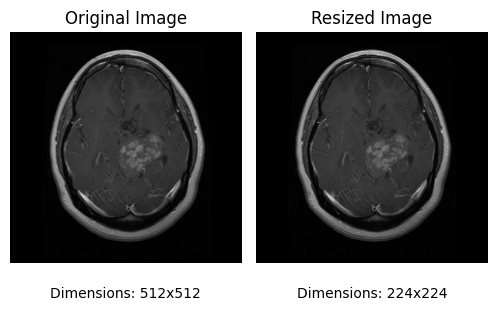

In [ ]:
# Displaying an original image and a resized image side-by-side for demonstration purposes

image_paths = ['/content/drive/MyDrive/Data 255 Project Data/All Training Images/gg (1).jpg']
original_images = [tf.io.read_file(image_path) for image_path in image_paths]
original_images = [tf.image.decode_jpeg(image) for image in original_images]

resized_images = []
for image in original_images:
    resized_image = tf.image.resize(image, (224, 224))
    resized_images.append(resized_image)

original_images = [tf.cast(image, tf.uint8) for image in original_images]
resized_images = [tf.cast(image, tf.uint8) for image in resized_images]

plt.figure(figsize=(10, 6))

for i, (original, resized) in enumerate(zip(original_images, resized_images)):
    # Original image(s)
    ax1 = plt.subplot(1, 4, i*2 + 1)
    plt.imshow(original)
    plt.title(f'Original Image')
    plt.axis('off')
    # Displaying the dimensions below the original image
    plt.text(0.5, -0.1, f'Dimensions: {original.shape[1]}x{original.shape[0]}',
             size=10, ha='center', va='top', transform=ax1.transAxes)

    # Resized image(s)
    ax2 = plt.subplot(1, 4, i*2 + 2)
    plt.imshow(resized)
    plt.title(f'Resized Image')
    plt.axis('off')
    # Displaying the dimensions below the resized image
    plt.text(0.5, -0.1, f'Dimensions: {resized.shape[1]}x{resized.shape[0]}',
             size=10, ha='center', va='top', transform=ax2.transAxes)

plt.tight_layout()
plt.show()

### **Model Training:**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc, precision_recall_fscore_support, confusion_matrix
import os
import random
import glob
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.stats import mode
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input as preprocess_input_vgg
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input as preprocess_input_inception
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input as preprocess_input_resnet
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input as preprocess_input_densenet
from tensorflow.keras.layers import Flatten, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
base_dir = "/content/drive/MyDrive/Data 255 Project Data"

train_df = pd.read_csv(f"{base_dir}/train_df_with_augmentation.csv")
val_df = pd.read_csv(f"{base_dir}/val_df.csv")
test_df = pd.read_csv(f"{base_dir}/test_df.csv")

train_image_dir = f'{base_dir}/All Training Images with Augmentation'
val_image_dir = f'{base_dir}/All Validation Images'
test_image_dir = f'{base_dir}/All Testing Images'

In [ ]:
train_df['Class'].value_counts()

pituitary_tumor     1200
meningioma_tumor    1200
no_tumor            1200
glioma_tumor        1200
Name: Class, dtype: int64

### **VGG19 Model:**

In [ ]:
# Function to preprocess the images to meet the requirements of the pertinent pre-trained model
def preprocess_image(file_path, label):
  img = tf.io.read_file(file_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (224, 224)) # Resizing to 224x224 for VGG19
  img = preprocess_input_vgg(img)  # Applying the preprocess function for VGG19
  return img, label

class_mapping = {'pituitary_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'glioma_tumor': 3}

# Function to prepare the train, validation and test datasets to be compatible with TensorFlow
def prepare_dataset(df, image_dir, preprocessing_function, batch_size=32, cache=True, shuffle=False):
    image_paths = df['Id'].apply(lambda x: f"{image_dir}/{x}").values
    df['Encoded Class'] = df['Class'].map(class_mapping)  # label encoding the target variable with the custom class mapping
    labels = df['Encoded Class'].values
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(image_paths))
    dataset = dataset.map(preprocessing_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    if cache:
        dataset = dataset.cache()
    return dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
batch_size = 32

# Preparing the train, validation and test datasets, with shuffling for the train dataset
train_dataset = prepare_dataset(train_df, train_image_dir, preprocess_image, batch_size=batch_size, cache=True, shuffle=True)
val_dataset = prepare_dataset(val_df, val_image_dir, preprocess_image, batch_size=batch_size, cache=True)
test_dataset = prepare_dataset(test_df, test_image_dir, preprocess_image, batch_size=batch_size, cache=True)

In [ ]:
# Loading the base VGG model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Adding custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x) # Flatten()(x)
#x = Dense(4096, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(4, activation='softmax')(x)

# Complete model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) # Using sparse categorical cross entropy since the classes are integer encoded

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=25,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)


Epoch 1/25
150/150 [==============================] - 29s 189ms/step - loss: 1.7165 - accuracy: 0.5383 - val_loss: 0.7855 - val_accuracy: 0.7108
Epoch 2/25
150/150 [==============================] - 29s 191ms/step - loss: 0.8712 - accuracy: 0.7121 - val_loss: 0.5397 - val_accuracy: 0.8049
Epoch 3/25
150/150 [==============================] - 27s 182ms/step - loss: 0.6518 - accuracy: 0.7758 - val_loss: 0.4424 - val_accuracy: 0.8502
Epoch 4/25
150/150 [==============================] - 27s 183ms/step - loss: 0.5062 - accuracy: 0.8123 - val_loss: 0.4137 - val_accuracy: 0.8850
Epoch 5/25
150/150 [==============================] - 28s 186ms/step - loss: 0.4626 - accuracy: 0.8279 - val_loss: 0.4083 - val_accuracy: 0.8780
Epoch 6/25
150/150 [==============================] - 28s 185ms/step - loss: 0.4395 - accuracy: 0.8310 - val_loss: 0.3752 - val_accuracy: 0.8815
Epoch 7/25
150/150 [==============================] - 27s 183ms/step - loss: 0.4121 - accuracy: 0.8458 - val_loss: 0.4041 - val_ac

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")
print(f"Test loss: {test_loss:.4f}")

13/13 [==============================] - 2s 158ms/step - loss: 1.3496 - accuracy: 0.6751
Test accuracy: 67.51%
Test loss: 1.3496


In [ ]:
print("The number of layers in the base model: ", len(base_model.layers))

The number of layers in the base model:  22


In [ ]:
# Fine-tuning the model (adapted from the fine-tuning tensorflow tutorial)

base_model.trainable = True

# Fine-tuning from this layer onwards
fine_tune_at = 17  # 15

# Freezing all the layers before the 'fine_tune_at' layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Compiling the model again for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_fine = model.fit(
    train_dataset,
    epochs=50,
    initial_epoch=history.epoch[-1],
    validation_data=val_dataset,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

Epoch 12/50
150/150 [==============================] - 34s 219ms/step - loss: 0.4801 - accuracy: 0.8402 - val_loss: 0.2431 - val_accuracy: 0.9129
Epoch 13/50
150/150 [==============================] - 32s 216ms/step - loss: 0.2098 - accuracy: 0.9215 - val_loss: 0.2008 - val_accuracy: 0.9268
Epoch 14/50
150/150 [==============================] - 31s 210ms/step - loss: 0.0993 - accuracy: 0.9625 - val_loss: 0.1500 - val_accuracy: 0.9617
Epoch 15/50
150/150 [==============================] - 32s 213ms/step - loss: 0.0804 - accuracy: 0.9717 - val_loss: 0.2024 - val_accuracy: 0.9443
Epoch 16/50
150/150 [==============================] - 32s 213ms/step - loss: 0.0575 - accuracy: 0.9810 - val_loss: 0.1656 - val_accuracy: 0.9512
Epoch 17/50
150/150 [==============================] - 32s 213ms/step - loss: 0.0487 - accuracy: 0.9831 - val_loss: 0.1440 - val_accuracy: 0.9582
Epoch 18/50
150/150 [==============================] - 32s 213ms/step - loss: 0.0359 - accuracy: 0.9883 - val_loss: 0.1723 -

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")
print(f"Test loss: {test_loss:.4f}")

13/13 [==============================] - 2s 161ms/step - loss: 3.6858 - accuracy: 0.7868
Test accuracy: 78.68%
Test loss: 3.6858


In [ ]:
model.save(f'{base_dir}/vgg19_transfer_learning_fine_tuned_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### **InceptionV3 Model:**

In [ ]:
# Function to preprocess the images to meet the requirements of the pertinent pre-trained model
def preprocess_image(file_path, label):
  img = tf.io.read_file(file_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (299, 299)) # Resizing to 299x299 for InceptionV3
  img = preprocess_input_inception(img)  # Applying the preprocess function for InceptionV3
  return img, label

class_mapping = {'pituitary_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'glioma_tumor': 3}

# Function to prepare the train, validation and test datasets to be compatible with TensorFlow
def prepare_dataset(df, image_dir, preprocessing_function, batch_size=32, cache=True, shuffle=False):
    image_paths = df['Id'].apply(lambda x: f"{image_dir}/{x}").values
    df['Encoded Class'] = df['Class'].map(class_mapping)  # label encoding the target variable with the custom class mapping
    labels = df['Encoded Class'].values
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(image_paths))
    dataset = dataset.map(preprocessing_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    if cache:
        dataset = dataset.cache()
    return dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
batch_size = 32

# Preparing the train, validation and test datasets, with shuffling for the train dataset
train_dataset = prepare_dataset(train_df, train_image_dir, preprocess_image, batch_size=batch_size, cache=True, shuffle=True)
val_dataset = prepare_dataset(val_df, val_image_dir, preprocess_image, batch_size=batch_size, cache=True)
test_dataset = prepare_dataset(test_df, test_image_dir, preprocess_image, batch_size=batch_size, cache=True)

In [ ]:
# Loading the base InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model.trainable = False

# Adding custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = Dense(4096, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(4, activation='softmax')(x)

# Complete model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) # Using sparse categorical cross entropy since the classes are integer encoded

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=25,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

Epoch 1/25
150/150 [==============================] - 25s 143ms/step - loss: 0.7715 - accuracy: 0.7004 - val_loss: 0.5197 - val_accuracy: 0.8153
Epoch 2/25
150/150 [==============================] - 21s 139ms/step - loss: 0.5090 - accuracy: 0.8102 - val_loss: 0.4385 - val_accuracy: 0.8641
Epoch 3/25
150/150 [==============================] - 20s 134ms/step - loss: 0.4222 - accuracy: 0.8471 - val_loss: 0.3972 - val_accuracy: 0.8746
Epoch 4/25
150/150 [==============================] - 20s 131ms/step - loss: 0.3891 - accuracy: 0.8548 - val_loss: 0.3810 - val_accuracy: 0.8780
Epoch 5/25
150/150 [==============================] - 20s 131ms/step - loss: 0.3604 - accuracy: 0.8679 - val_loss: 0.3636 - val_accuracy: 0.8746
Epoch 6/25
150/150 [==============================] - 20s 132ms/step - loss: 0.3333 - accuracy: 0.8810 - val_loss: 0.3530 - val_accuracy: 0.8746
Epoch 7/25
150/150 [==============================] - 20s 133ms/step - loss: 0.3135 - accuracy: 0.8906 - val_loss: 0.3392 - val_ac

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")
print(f"Test loss: {test_loss:.4f}")

13/13 [==============================] - 2s 118ms/step - loss: 1.1327 - accuracy: 0.6954
Test accuracy: 69.54%
Test loss: 1.1327


In [ ]:
print("The number of layers in the base model: ", len(base_model.layers))

The number of layers in the base model:  311


In [ ]:
# Fine-tuning the model

base_model.trainable = True

# Fine-tuning from this layer onwards
fine_tune_at = 200

# Freezing all the layers before the 'fine_tune_at' layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Compiling the model again for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_fine = model.fit(
    train_dataset,
    epochs=50,
    initial_epoch=history.epoch[-1],
    validation_data=val_dataset,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

Epoch 21/50
150/150 [==============================] - 44s 223ms/step - loss: 0.3473 - accuracy: 0.8904 - val_loss: 0.1990 - val_accuracy: 0.9373
Epoch 22/50
150/150 [==============================] - 32s 212ms/step - loss: 0.0288 - accuracy: 0.9900 - val_loss: 0.1432 - val_accuracy: 0.9582
Epoch 23/50
150/150 [==============================] - 31s 207ms/step - loss: 0.0054 - accuracy: 0.9990 - val_loss: 0.0869 - val_accuracy: 0.9652
Epoch 24/50
150/150 [==============================] - 31s 208ms/step - loss: 0.0016 - accuracy: 0.9996 - val_loss: 0.1080 - val_accuracy: 0.9617
Epoch 25/50
150/150 [==============================] - 31s 210ms/step - loss: 3.7519e-04 - accuracy: 1.0000 - val_loss: 0.1100 - val_accuracy: 0.9617
Epoch 26/50
150/150 [==============================] - 31s 210ms/step - loss: 2.2945e-04 - accuracy: 1.0000 - val_loss: 0.1096 - val_accuracy: 0.9652


In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")
print(f"Test loss: {test_loss:.4f}")

13/13 [==============================] - 2s 113ms/step - loss: 2.0428 - accuracy: 0.8401
Test accuracy: 84.01%
Test loss: 2.0428


In [ ]:
model.save(f'{base_dir}/inceptionv3_transfer_learning_fine_tuned_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### **ResNet50 Model:**

In [ ]:
# Function to preprocess the images to meet the requirements of the pertinent pre-trained model
def preprocess_image(file_path, label):
  img = tf.io.read_file(file_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (224, 224)) # Resizing to 224x224 for ResNet50
  img = preprocess_input_resnet(img)  # Applying the preprocess function for ResNet50
  return img, label

class_mapping = {'pituitary_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'glioma_tumor': 3}

# Function to prepare the train, validation and test datasets to be compatible with TensorFlow
def prepare_dataset(df, image_dir, preprocessing_function, batch_size=32, cache=True, shuffle=False):
    image_paths = df['Id'].apply(lambda x: f"{image_dir}/{x}").values
    df['Encoded Class'] = df['Class'].map(class_mapping)  # label encoding the target variable with the custom class mapping
    labels = df['Encoded Class'].values
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(image_paths))
    dataset = dataset.map(preprocessing_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    if cache:
        dataset = dataset.cache()
    return dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
batch_size = 32

# Preparing the train, validation and test datasets, with shuffling for the train dataset
train_dataset = prepare_dataset(train_df, train_image_dir, preprocess_image, batch_size=batch_size, cache=True, shuffle=True)
val_dataset = prepare_dataset(val_df, val_image_dir, preprocess_image, batch_size=batch_size, cache=True)
test_dataset = prepare_dataset(test_df, test_image_dir, preprocess_image, batch_size=batch_size, cache=True)

In [ ]:
# Loading the base ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Adding custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = Dense(4096, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(4, activation='softmax')(x)

# Complete model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) # Using sparse categorical cross entropy since the classes are integer encoded

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=25,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

Epoch 1/25
150/150 [==============================] - 21s 122ms/step - loss: 0.6859 - accuracy: 0.7269 - val_loss: 0.4374 - val_accuracy: 0.8362
Epoch 2/25
150/150 [==============================] - 17s 114ms/step - loss: 0.3951 - accuracy: 0.8487 - val_loss: 0.3887 - val_accuracy: 0.8676
Epoch 3/25
150/150 [==============================] - 16s 109ms/step - loss: 0.3310 - accuracy: 0.8810 - val_loss: 0.3557 - val_accuracy: 0.8780
Epoch 4/25
150/150 [==============================] - 16s 108ms/step - loss: 0.2837 - accuracy: 0.8950 - val_loss: 0.3384 - val_accuracy: 0.8850
Epoch 5/25
150/150 [==============================] - 16s 108ms/step - loss: 0.2531 - accuracy: 0.9112 - val_loss: 0.3142 - val_accuracy: 0.8955
Epoch 6/25
150/150 [==============================] - 16s 109ms/step - loss: 0.2364 - accuracy: 0.9112 - val_loss: 0.2984 - val_accuracy: 0.8955
Epoch 7/25
150/150 [==============================] - 16s 109ms/step - loss: 0.2177 - accuracy: 0.9204 - val_loss: 0.2845 - val_ac

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")
print(f"Test loss: {test_loss:.4f}")

13/13 [==============================] - 1s 98ms/step - loss: 1.2651 - accuracy: 0.7411
Test accuracy: 74.11%
Test loss: 1.2651


In [ ]:
print("The number of layers in the base model: ", len(base_model.layers))

The number of layers in the base model:  175


In [ ]:
# Fine-tuning the model

base_model.trainable = True

# Fine-tuning from this layer onwards
fine_tune_at = 100

# Freezing all the layers before the 'fine_tune_at' layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Compiling the model again for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_fine = model.fit(
    train_dataset,
    epochs=50,
    initial_epoch=history.epoch[-1],
    validation_data=val_dataset,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

Epoch 16/25
150/150 [==============================] - 42s 198ms/step - loss: 0.2550 - accuracy: 0.9177 - val_loss: 0.2179 - val_accuracy: 0.9408
Epoch 17/25
150/150 [==============================] - 29s 190ms/step - loss: 0.0344 - accuracy: 0.9894 - val_loss: 0.1574 - val_accuracy: 0.9652
Epoch 18/25
150/150 [==============================] - 28s 187ms/step - loss: 0.0115 - accuracy: 0.9962 - val_loss: 0.1684 - val_accuracy: 0.9477
Epoch 19/25
150/150 [==============================] - 28s 189ms/step - loss: 0.0023 - accuracy: 0.9996 - val_loss: 0.1371 - val_accuracy: 0.9721
Epoch 20/25
150/150 [==============================] - 28s 188ms/step - loss: 8.0073e-04 - accuracy: 1.0000 - val_loss: 0.1404 - val_accuracy: 0.9686
Epoch 21/25
150/150 [==============================] - 28s 189ms/step - loss: 2.8999e-04 - accuracy: 1.0000 - val_loss: 0.1329 - val_accuracy: 0.9756
Epoch 22/25
150/150 [==============================] - 28s 188ms/step - loss: 1.3321e-04 - accuracy: 1.0000 - val_lo

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")
print(f"Test loss: {test_loss:.4f}")

13/13 [==============================] - 1s 98ms/step - loss: 2.2461 - accuracy: 0.8198
Test accuracy: 81.98%
Test loss: 2.2461


In [ ]:
model.save(f'{base_dir}/resnet50_transfer_learning_fine_tuned_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### **DenseNet121 Model:**

In [ ]:
# Function to preprocess the images to meet the requirements of the pertinent pre-trained model
def preprocess_image(file_path, label):
  img = tf.io.read_file(file_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (224, 224)) # Resizing to 224x224 for DenseNet121
  img = preprocess_input_densenet(img)  # Applying the preprocess function for DenseNet121
  return img, label

class_mapping = {'pituitary_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'glioma_tumor': 3}

# Function to prepare the train, validation and test datasets to be compatible with TensorFlow
def prepare_dataset(df, image_dir, preprocessing_function, batch_size=32, cache=True, shuffle=False):
    image_paths = df['Id'].apply(lambda x: f"{image_dir}/{x}").values
    df['Encoded Class'] = df['Class'].map(class_mapping)  # label encoding the target variable with the custom class mapping
    labels = df['Encoded Class'].values
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(image_paths))
    dataset = dataset.map(preprocessing_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    if cache:
        dataset = dataset.cache()
    return dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
batch_size = 32

# Preparing the train, validation and test datasets, with shuffling for the train dataset
train_dataset = prepare_dataset(train_df, train_image_dir, preprocess_image, batch_size=batch_size, cache=True, shuffle=True)
val_dataset = prepare_dataset(val_df, val_image_dir, preprocess_image, batch_size=batch_size, cache=True)
test_dataset = prepare_dataset(test_df, test_image_dir, preprocess_image, batch_size=batch_size, cache=True)

In [ ]:
# Loading the base DenseNet121 model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Adding custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = Dense(4096, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(4, activation='softmax')(x)

# Complete model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) # Using sparse categorical cross entropy since the classes are integer encoded

29084464/29084464 [==============================] - 2s 0us/step


In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=25,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

Epoch 1/25
150/150 [==============================] - 27s 131ms/step - loss: 0.9729 - accuracy: 0.5960 - val_loss: 0.6187 - val_accuracy: 0.7770
Epoch 2/25
150/150 [==============================] - 16s 108ms/step - loss: 0.5910 - accuracy: 0.7790 - val_loss: 0.5029 - val_accuracy: 0.8188
Epoch 3/25
150/150 [==============================] - 16s 106ms/step - loss: 0.5102 - accuracy: 0.8067 - val_loss: 0.4654 - val_accuracy: 0.8223
Epoch 4/25
150/150 [==============================] - 16s 104ms/step - loss: 0.4580 - accuracy: 0.8279 - val_loss: 0.4318 - val_accuracy: 0.8328
Epoch 5/25
150/150 [==============================] - 15s 103ms/step - loss: 0.4192 - accuracy: 0.8346 - val_loss: 0.4109 - val_accuracy: 0.8432
Epoch 6/25
150/150 [==============================] - 15s 102ms/step - loss: 0.4009 - accuracy: 0.8465 - val_loss: 0.4315 - val_accuracy: 0.8362
Epoch 7/25
150/150 [==============================] - 16s 104ms/step - loss: 0.3841 - accuracy: 0.8571 - val_loss: 0.3928 - val_ac

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")
print(f"Test loss: {test_loss:.4f}")

13/13 [==============================] - 3s 203ms/step - loss: 1.1656 - accuracy: 0.6675
Test accuracy: 66.75%
Test loss: 1.1656


In [ ]:
print("The number of layers in the base model: ", len(base_model.layers))

The number of layers in the base model:  427


In [ ]:
# Fine-tuning the model

base_model.trainable = True

# Fine-tuning from this layer onwards
fine_tune_at = 300

# Freezing all the layers before the 'fine_tune_at' layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Compiling the model again for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_fine = model.fit(
    train_dataset,
    epochs=50,
    initial_epoch=history.epoch[-1],
    validation_data=val_dataset,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

Epoch 10/50
150/150 [==============================] - 40s 142ms/step - loss: 0.3328 - accuracy: 0.8790 - val_loss: 0.2068 - val_accuracy: 0.9199
Epoch 11/50
150/150 [==============================] - 20s 131ms/step - loss: 0.0621 - accuracy: 0.9825 - val_loss: 0.1584 - val_accuracy: 0.9303
Epoch 12/50
150/150 [==============================] - 19s 128ms/step - loss: 0.0215 - accuracy: 0.9967 - val_loss: 0.1439 - val_accuracy: 0.9408
Epoch 13/50
150/150 [==============================] - 19s 127ms/step - loss: 0.0095 - accuracy: 0.9992 - val_loss: 0.1396 - val_accuracy: 0.9408
Epoch 14/50
150/150 [==============================] - 19s 127ms/step - loss: 0.0049 - accuracy: 0.9998 - val_loss: 0.1360 - val_accuracy: 0.9547
Epoch 15/50
150/150 [==============================] - 19s 127ms/step - loss: 0.0034 - accuracy: 0.9998 - val_loss: 0.1377 - val_accuracy: 0.9443
Epoch 16/50
150/150 [==============================] - 19s 128ms/step - loss: 0.0038 - accuracy: 0.9998 - val_loss: 0.1389 -

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")
print(f"Test loss: {test_loss:.4f}")

13/13 [==============================] - 1s 93ms/step - loss: 2.1940 - accuracy: 0.7995
Test accuracy: 79.95%
Test loss: 2.1940


In [ ]:
model.save(f'{base_dir}/densenet_transfer_learning_fine_tuned_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### **Model Ensemble:**

In [ ]:
model_vgg19 = load_model(f'{base_dir}/vgg19_transfer_learning_fine_tuned_model.h5')
model_inceptionv3 = load_model(f'{base_dir}/inceptionv3_transfer_learning_fine_tuned_model.h5')
model_resnet50 = load_model(f'{base_dir}/resnet50_transfer_learning_fine_tuned_model.h5')
model_densenet121 = load_model(f'{base_dir}/densenet_transfer_learning_fine_tuned_model.h5')

In [ ]:
# Functions to preprocess the images to meet the requirements of the pertinent pre-trained model
def preprocess_image_vgg19(file_path, label):
  img = tf.io.read_file(file_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (224, 224))
  img = preprocess_input_vgg(img)
  return img, label

def preprocess_image_inceptionv3(file_path, label):
  img = tf.io.read_file(file_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (299, 299))
  img = preprocess_input_inception(img)
  return img, label

def preprocess_image_resnet50(file_path, label):
  img = tf.io.read_file(file_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (224, 224))
  img = preprocess_input_resnet(img)
  return img, label

def preprocess_image_densenet121(file_path, label):
  img = tf.io.read_file(file_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (224, 224))
  img = preprocess_input_densenet(img)
  return img, label

class_mapping = {'pituitary_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'glioma_tumor': 3}

# Function to prepare the test dataset to be compatible with TensorFlow
def prepare_dataset(df, image_dir, preprocessing_function, batch_size=32, cache=True, shuffle=False):
    image_paths = df['Id'].apply(lambda x: f"{image_dir}/{x}").values
    df['Encoded Class'] = df['Class'].map(class_mapping)  # label encoding the target variable with the custom class mapping
    labels = df['Encoded Class'].values
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(image_paths))
    dataset = dataset.map(preprocessing_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    if cache:
        dataset = dataset.cache()
    return dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
# Preparing the test dataset to be compatible with each of the models using the above functions
test_dataset_vgg19 = prepare_dataset(test_df, test_image_dir, preprocess_image_vgg19, batch_size=batch_size, cache=True)
test_dataset_inceptionv3 = prepare_dataset(test_df, test_image_dir, preprocess_image_inceptionv3, batch_size=batch_size, cache=True)
test_dataset_resnet50 = prepare_dataset(test_df, test_image_dir, preprocess_image_resnet50, batch_size=batch_size, cache=True)
test_dataset_densenet121 = prepare_dataset(test_df, test_image_dir, preprocess_image_densenet121, batch_size=batch_size, cache=True)

In [ ]:
# Making class probability predictions for each model
predictions_vgg19 = model_vgg19.predict(test_dataset_vgg19)
predictions_inceptionv3 = model_inceptionv3.predict(test_dataset_inceptionv3)
predictions_resnet50 = model_resnet50.predict(test_dataset_resnet50)
predictions_densenet121 = model_densenet121.predict(test_dataset_densenet121)

13/13 [==============================] - 3s 95ms/step


In [ ]:
# Using soft-voting to make predictions
ensemble_predictions = (predictions_vgg19 + predictions_inceptionv3 + predictions_resnet50 + predictions_densenet121) / 4

true_classes = test_df['Class'].map(class_mapping).values
predicted_classes = np.argmax(ensemble_predictions, axis=1)

ensemble_model_acc = accuracy_score(true_classes, predicted_classes)
print(f'Ensemble Model Accuracy: {ensemble_model_acc}')

Ensemble Model Accuracy: 0.817258883248731


In [ ]:
# Making class predictions for each model
class_predictions_vgg19 = np.argmax(model_vgg19.predict(test_dataset_vgg19), axis=1)
class_predictions_inceptionv3 = np.argmax(model_inceptionv3.predict(test_dataset_inceptionv3), axis=1)
class_predictions_resnet50 = np.argmax(model_resnet50.predict(test_dataset_resnet50), axis=1)
class_predictions_densenet121 = np.argmax(model_densenet121.predict(test_dataset_densenet121), axis=1)

13/13 [==============================] - 1s 97ms/step


In [ ]:
# Using majority voting to make predictions
stacked_predictions = np.column_stack((class_predictions_vgg19, class_predictions_inceptionv3, class_predictions_resnet50, class_predictions_densenet121))
ensemble_predictions = mode(stacked_predictions, axis=1)[0].flatten()

true_classes = test_df['Class'].map(class_mapping).values

ensemble_model_acc = accuracy_score(true_classes, ensemble_predictions)
print(f'Ensemble Model Accuracy: {ensemble_model_acc}')

Ensemble Model Accuracy: 0.8197969543147208


## **The ensemble model accuracy of 81.98% is lower than the InceptionV3 model accuracy of 84.01% (most likely due to the correlation of the errors of the individual models, the individual models might not be diverse enough). Thus, the InceptionV3 model is chosen as the final model.**

In [ ]:
# Loading the InceptionV3 model

model_inceptionv3 = load_model(f'{base_dir}/inceptionv3_transfer_learning_fine_tuned_model.h5')

In [ ]:
# Functions to preprocess the images to meet the requirements of the pertinent pre-trained model
def preprocess_image_inceptionv3(file_path, label):
  img = tf.io.read_file(file_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (299, 299))
  img = preprocess_input_inception(img)
  return img, label

class_mapping = {'pituitary_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'glioma_tumor': 3}

# Function to prepare the test dataset to be compatible with TensorFlow
def prepare_dataset(df, image_dir, preprocessing_function, batch_size=32, cache=True, shuffle=False):
    image_paths = df['Id'].apply(lambda x: f"{image_dir}/{x}").values
    df['Encoded Class'] = df['Class'].map(class_mapping)  # label encoding the target variable with the custom class mapping
    labels = df['Encoded Class'].values
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(image_paths))
    dataset = dataset.map(preprocessing_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    if cache:
        dataset = dataset.cache()
    return dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Preparing the test dataset to be compatible with the InceptionV3 model using the above functions
test_dataset_inceptionv3 = prepare_dataset(test_df, test_image_dir, preprocess_image_inceptionv3, batch_size=batch_size, cache=True)

In [ ]:
class_predictions_inceptionv3 = np.argmax(model_inceptionv3.predict(test_dataset_inceptionv3), axis=1)
true_classes = test_df['Class'].map(class_mapping).values

inceptionv3_model_acc = accuracy_score(true_classes, class_predictions_inceptionv3)
print(f'InceptionV3 Model Accuracy: {inceptionv3_model_acc}')

13/13 [==============================] - 3s 129ms/step
InceptionV3 Model Accuracy: 0.8401015228426396


In [ ]:
class_probabilities_inceptionv3 = model_inceptionv3.predict(test_dataset_inceptionv3)

# Computing the macro average ROC-AUC score
roc_auc = roc_auc_score(tf.keras.utils.to_categorical(true_classes, 4), class_probabilities_inceptionv3, multi_class='ovr', average='macro')
print(f'Macro average ROC-AUC score: {roc_auc}')

13/13 [==============================] - 2s 129ms/step
Macro average ROC-AUC score: 0.9471445814660587


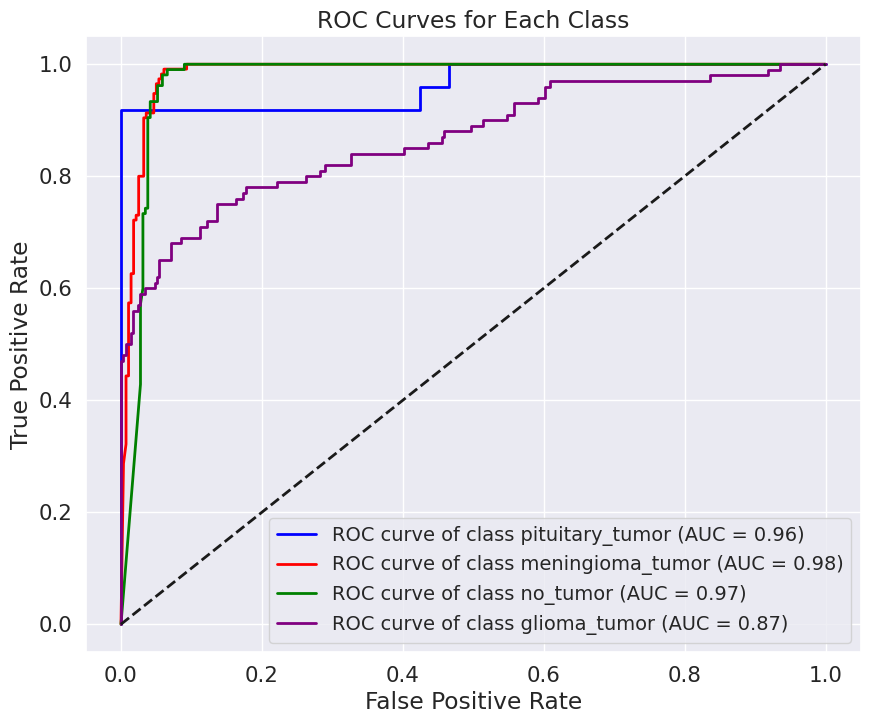

In [ ]:
# Plotting ROC Curves for each class

# Inverting the class mapping dictionary
inv_mapping = {v: k for k, v in class_mapping.items()}
class_names = [inv_mapping[i] for i in range(4)]

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(class_names)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(tf.keras.utils.to_categorical(true_classes, n_classes)[:, i], class_probabilities_inceptionv3[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'purple']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (AUC = {1:0.2f})'
             ''.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc="lower right", fontsize="small")
plt.show()

In [ ]:
# Classification report
report = classification_report(true_classes, class_predictions_inceptionv3, target_names=class_names)
print(report)

                  precision    recall  f1-score   support

 pituitary_tumor       1.00      0.88      0.94        74
meningioma_tumor       0.81      1.00      0.89       115
        no_tumor       0.74      1.00      0.85       105
    glioma_tumor       1.00      0.46      0.63       100

        accuracy                           0.84       394
       macro avg       0.89      0.83      0.83       394
    weighted avg       0.88      0.84      0.82       394



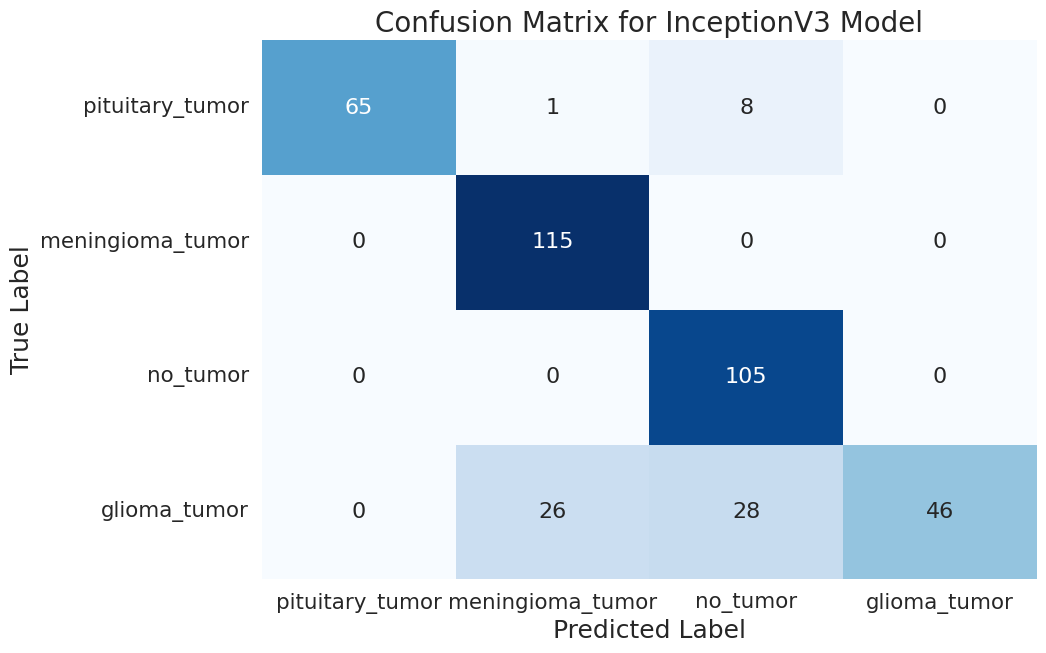

In [ ]:
# Plotting the confusion matrix using Seaborn

cm = confusion_matrix(true_classes, class_predictions_inceptionv3)
plt.figure(figsize=(10, 7))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Label', fontsize=18)
plt.ylabel('True Label', fontsize=18)
plt.title('Confusion Matrix for InceptionV3 Model', fontsize=20)
plt.show()

1/1 [==============================] - 0s 28ms/step


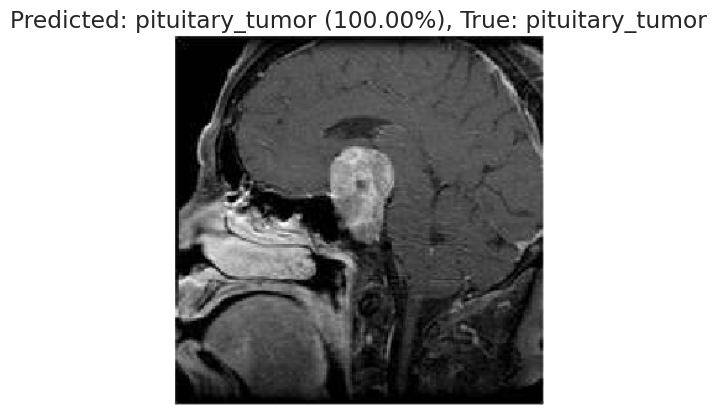

In [ ]:
# Inference on a random sample image from the testing images directory

# Randomly picking an image
random_filename = random.choice(os.listdir(test_image_dir))
img_path = os.path.join(test_image_dir, random_filename)

# Loading and preprocessing the image
img = image.load_img(img_path, target_size=(299, 299))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input_inception(img_array)

# Predicting the class
probabilities = model_inceptionv3.predict(img_array)
predicted_class_index = np.argmax(probabilities[0])
confidence = np.max(probabilities[0])

# Getting the predicted class name
predicted_class_name = inv_mapping[predicted_class_index]

# Getting the true label from test_df
true_label = test_df[test_df['Id'] == random_filename]['Class'].values[0]

# Displaying the image
plt.imshow(img)
plt.title(f'Predicted: {predicted_class_name} ({confidence * 100:.2f}%), True: {true_label}')
plt.axis('off')
plt.show()